In [1]:
# run stopwatch
from tools import Stopwatch
stopwatch = Stopwatch()
start = stopwatch.start()

### Load libraries, functions, palette, theme

In [2]:
%run _libraries.ipynb

In [3]:
%run _functions.ipynb

In [4]:
dir_current = '03-arima-month'

In [5]:
dir_save_files = 'files/'

In [6]:
dir_load_files = 'files/'

In [7]:
dir_save_img = 'docs/img/'

In [8]:
session_name = dir_current

# Section III. ARIMA

## Load Saved Section if exists

## Load Data

In [9]:
train = loadit('train_preprocessed', dir=dir_load_files)

In [10]:
valid = loadit('valid_preprocessed', dir=dir_load_files)

In [11]:
test = loadit('test_preprocessed', dir=dir_load_files)

## Stationarity

p< 0.05: Enough evidence to say, that process is stationarity

In [12]:
# NULL: non-stationarity
sm.tsa.stattools.adfuller(train['target1'])

(-28.686047970170506,
 0.0,
 47,
 30480,
 {'1%': -3.4305645620343594,
  '5%': -2.8616348306743395,
  '10%': -2.566820475464527},
 460471.5647015386)

In [13]:
# NULL: non-stationarity
sm.tsa.stattools.adfuller(train['target1'])

(-28.686047970170506,
 0.0,
 47,
 30480,
 {'1%': -3.4305645620343594,
  '5%': -2.8616348306743395,
  '10%': -2.566820475464527},
 460471.5647015386)

## Autocorrelation

#### ACF - 40 period

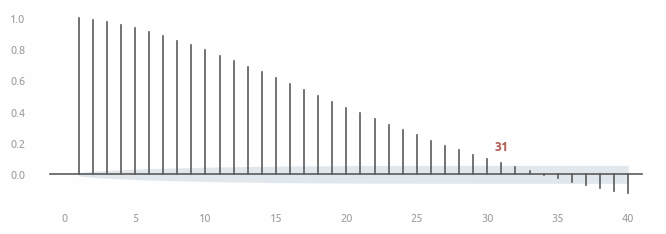

In [569]:
fig = plt.figure()
plot_acf(data=train['target1'], lags=40)
acf_text = f'{ts_acf_last_significant_index(train['target1'])}'
plt.annotate(
    text=acf_text,
    xy=(ts_acf_last_significant_index(train['target1']), 0.15),
    ha='center',
    size=9,
    color=palette[1],
    weight='bold');

In [15]:
ts_acf_last_significant_index(train['target1'])

31

#### ACF - 300 period

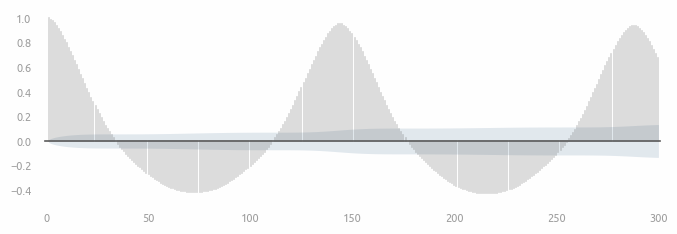

In [16]:
plot_acf(data=train['target1'], lags=300, transparency_lines=0.25)

#### PACF - 40 period

In [17]:
pacf = ts_acf_calculate(train['target1'], lags=36, partial=True)

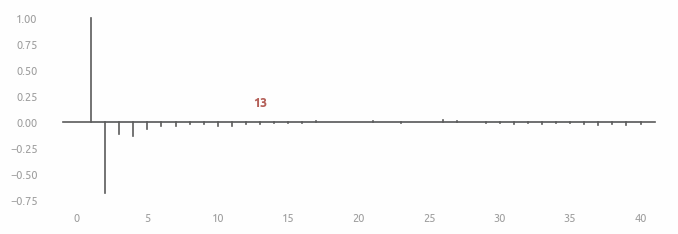

In [570]:
fig = plt.figure()
plot_acf(data=train['target1'], partial=True)
pacf_text = f'{ts_acf_last_significant_index(data=train['target1'], partial=True)}'
plt.annotate(
    text=pacf_text,
    xy=(ts_acf_last_significant_index(data=train['target1'], partial=True), 0.15),
    ha='center',
    size=9,
    color=palette[1],
    weight='bold');

In [19]:
ts_acf_last_significant_index(data=train['target1'], partial=True)

13

## Model №1: ARIMA without seasonality and exogs

### Datasets

Train: July data;  
Validation: August data.

In [20]:
y = train.loc['2017-07-01':, 'target1'].copy()

In [21]:
y

2017-07-01 00:00:00    36384.31894
2017-07-01 00:10:00    35689.03654
2017-07-01 00:20:00    34751.36213
2017-07-01 00:30:00    33954.01993
2017-07-01 00:40:00    33411.82724
                          ...     
2017-07-31 23:10:00    43407.30897
2017-07-31 23:20:00    42507.90698
2017-07-31 23:30:00    41659.53488
2017-07-31 23:40:00    40843.05648
2017-07-31 23:50:00    39631.09635
Freq: 10min, Name: target1, Length: 4464, dtype: float64

In [22]:
y_true = valid['target1'].copy()

In [23]:
y_true

2017-08-01 00:00:00    38517.20311
2017-08-01 00:10:00    37973.80688
2017-08-01 00:20:00    37308.94562
2017-08-01 00:30:00    36164.61709
2017-08-01 00:40:00    35678.75694
                          ...     
2017-08-31 23:10:00    38619.48946
2017-08-31 23:20:00    38370.16648
2017-08-31 23:30:00    37724.48391
2017-08-31 23:40:00    36874.22863
2017-08-31 23:50:00    36215.76027
Freq: 10min, Name: target1, Length: 4464, dtype: float64

### ACF and PACF for differenced data

Images 'PACF.png' and 'PACF.svg' successfully saved into 'docs/img/' directory


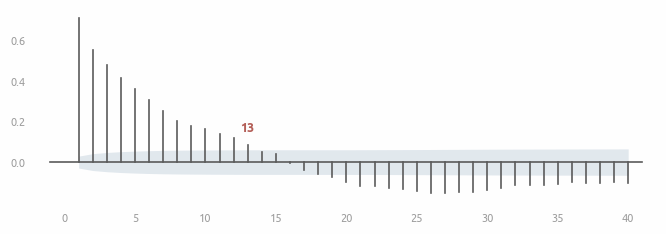

In [24]:
plot_acf(data=y.diff(1)[1:])
acf_text = f'{ts_acf_last_significant_index(data=y.diff(1)[1:])}'
plt.annotate(
    text=acf_text,
    xy=(ts_acf_last_significant_index(data=y.diff(1)[1:]), 0.15),
    ha='center',
    size=9,
    color=palette[1],
    weight='bold')
savefig('PACF', dir_save_img)

Images 'PACF.png' and 'PACF.svg' successfully saved into 'docs/img/' directory


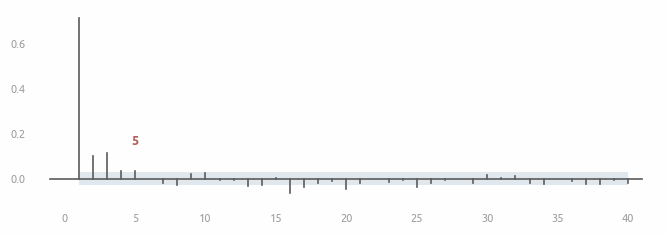

In [25]:
plot_acf(data=y.diff(1)[1:], partial=True)
pacf_text = f'{ts_acf_last_significant_index(data=y.diff(1)[1:], partial=True)}'
plt.annotate(
    text=pacf_text,
    xy=(ts_acf_last_significant_index(data=y.diff(1)[1:], partial=True), 0.15),
    ha='center',
    size=9,
    color=palette[1],
    weight='bold')
savefig('PACF', dir_save_img)

### Model selection

#### Manual model selection

In [26]:
arima311 = SARIMAX(
    y, exog=None,
    order=(3,1,1),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

In [27]:
print(arima311.summary())

                               SARIMAX Results                                
Dep. Variable:                target1   No. Observations:                 4464
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -33786.005
Date:                Sat, 13 Apr 2024   AIC                          67582.010
Time:                        19:51:07   BIC                          67614.028
Sample:                    07-01-2017   HQIC                         67593.296
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9631      0.107      9.015      0.000       0.754       1.173
ar.L2         -0.2024      0.064     -3.180      0.001      -0.327      -0.078
ar.L3          0.0751      0.017      4.526      0.0

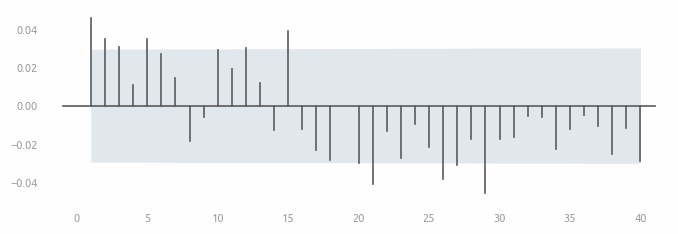

In [28]:
# should plot resid[d:], where d is d-order of ARIMA model
plot_acf(data=arima311.resid[1:])

In [29]:
arima411 = SARIMAX(
    y, exog=None,
    order=(4,1,1),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

In [30]:
arima411.aic < arima311.aic

False

In [31]:
arima411.aic

67583.9319638164

In [32]:
arima311.aic

67582.0097609724

In [33]:
arima511 = SARIMAX(
    y, exog=None,
    order=(5,1,1),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

In [34]:
arima511.aic < arima311.aic

False

In [35]:
arima511.aic

67583.69728990004

In [36]:
arima412 = SARIMAX(
    y, exog=None,
    order=(4,1,2),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

In [37]:
arima412.aic < arima311.aic

True

In [38]:
arima412.aic

67470.5863748277

In [39]:
arima413 = SARIMAX(
    y, exog=None,
    order=(4,1,3),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [40]:
arima413.aic < arima412.aic

False

In [41]:
arima414 = SARIMAX(
    y, exog=None,
    order=(4,1,4),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [42]:
arima414.aic < arima412.aic

False

In [43]:
arima612 = SARIMAX(
    y, exog=None,
    order=(6,1,2),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

In [44]:
arima612.aic < arima412.aic

False

In [45]:
arima613 = SARIMAX(
    y, exog=None,
    order=(6,1,3),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [46]:
arima613.aic < arima412.aic

False

#### Automatic model selection

In [47]:
%%time
model_auto = auto_arima(y)

CPU times: user 51.4 s, sys: 5.89 s, total: 57.3 s
Wall time: 30.7 s


In [48]:
model_auto

ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [49]:
arima_auto = SARIMAX(
    y, exog=None,
    order=(1,1,2),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

In [50]:
print(model_auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4464
Model:               SARIMAX(1, 1, 2)   Log Likelihood              -33786.090
Date:                Sat, 13 Apr 2024   AIC                          67580.181
Time:                        19:52:10   BIC                          67605.795
Sample:                    07-01-2017   HQIC                         67589.210
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8373      0.010     82.181      0.000       0.817       0.857
ma.L1         -0.2494      0.013    -19.557      0.000      -0.274      -0.224
ma.L2         -0.1273      0.014     -9.032      0.0

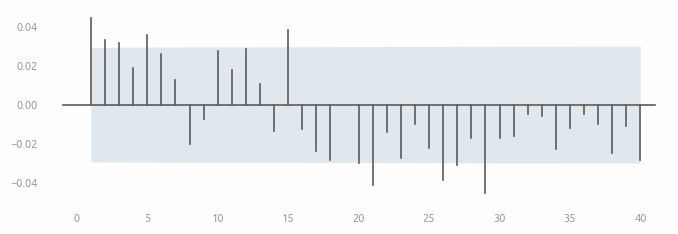

In [51]:
# should plot resid[d:], where d is d-order of ARIMA model
plot_acf(data=model_auto.resid()[1:])

In [52]:
test_LLR(arima412, arima_auto)

p-value: 1.0


In [53]:
arima_auto.aic < arima412.aic

False

In [54]:
arima_auto.aic

67580.18091941482

In [55]:
arima412.aic

67470.5863748277

#### Final ARIMA

In [56]:
arima = arima412

In [57]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                target1   No. Observations:                 4464
Model:               SARIMAX(4, 1, 2)   Log Likelihood              -33728.293
Date:                Sat, 13 Apr 2024   AIC                          67470.586
Time:                        19:52:11   BIC                          67515.411
Sample:                    07-01-2017   HQIC                         67486.388
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2786      0.053     42.640      0.000       2.174       2.383
ar.L2         -1.6635      0.084    -19.903      0.000      -1.827      -1.500
ar.L3          0.4148      0.031     13.597      0.0

#### Forecast

In [58]:
len(y_true)

4464

In [59]:
arima_f = ts_arima_forecast(arima, steps=4464, data=y.to_frame(), ci=[80, 95])

In [60]:
arima_f

,data,is_forecast,lower_ci80,upper_ci80,lower_ci95,upper_ci95
2017-07-01 00:00:00,36384.318940,0,NaN,NaN,NaN,NaN
2017-07-01 00:10:00,35689.036540,0,NaN,NaN,NaN,NaN
2017-07-01 00:20:00,34751.362130,0,NaN,NaN,NaN,NaN
2017-07-01 00:30:00,33954.019930,0,NaN,NaN,NaN,NaN
2017-07-01 00:40:00,33411.827240,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2017-08-31 23:10:00,35802.234822,1,27839.359167,43765.110476,23624.067422,47980.402221
2017-08-31 23:20:00,35802.234822,1,27839.356669,43765.112975,23624.063601,47980.406042
2017-08-31 23:30:00,35802.234822,1,27839.354171,43765.115473,23624.059780,47980.409863
2017-08-31 23:40:00,35802.234822,1,27839.351672,43765.117971,23624.055960,47980.413684


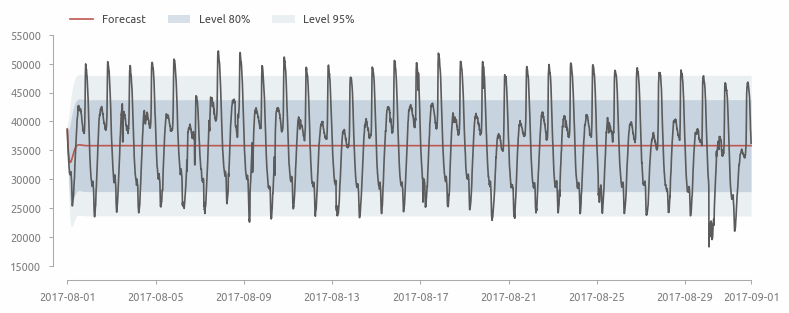

Images 'auto_arima.png' and 'auto_arima.svg' successfully saved into 'docs/img/' directory


In [61]:
plt.figure(figsize=(9, 3))
ts_plot_arima_forecast(arima_f.iloc[-4464:, :])
plt.plot(y_true, color=saturate_color(palette[0], 1))
axis_rstyle()
plt.show()

savefig('auto_arima', dir_save_img)

In [62]:
arima_forecast = arima_f.loc[arima_f['is_forecast']==1, 'data']

##### MAE

In [63]:
mean_absolute_error(arima_forecast, y_true)

5916.834641754048

##### MAPE

In [64]:
mean_absolute_percentage_error(arima_forecast, y_true) * 100

16.532017181095302

##### RMSE

In [65]:
root_mean_squared_error(arima_forecast, y_true)

7075.002257346598

## Model №2: ARIMA with seasonality

### Fourier transform

In [66]:
y_values = y.values

In [67]:
y_values_trend = scipy.signal.savgol_filter(y_values, 25, 1)

In [68]:
y_values_detrended = y_values - y_values_trend

In [69]:
fft_x = np.fft.fftfreq(len(y_values_detrended))
fft_x = fft_x[:len(fft_x)//2]

In [70]:
fft_y = np.fft.fft(y_values_detrended)
fft_y = np.abs(fft_y[:len(fft_y)//2])

In [71]:
fft_y_peaks_indices = get_peaks_indicies(fft_y, boundary=500000)

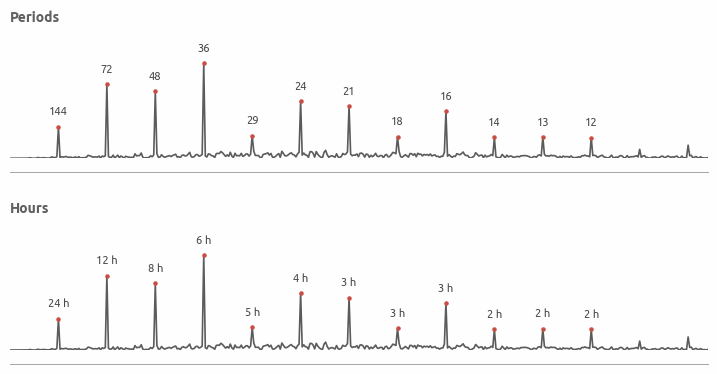

Images 'fourier_transform.png' and 'fourier_transform.svg' successfully saved into 'docs/img/' directory


In [72]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4))

plt.subplot(2, 1, 1)
plt.plot(fft_x, fft_y)
for idx in fft_y_peaks_indices:
    x_, y_ = fft_x[idx], fft_y[idx]
    text = f'{round(1/x_)}'
    plt.annotate(text, (x_, y_+300000), ha='center', size=8)
    plt.scatter(
        fft_x[idx], fft_y[idx],
        color=saturate_color(palette[1], 1.5), marker='.', s=20, zorder=10)

plt.title('Periods')
plt.xlim(0, 0.1)
plt.ylim(0, 3000000)
axis_rstyle(y_axis_hide=True, y_ticklabels_hide=True, x_ticklabels_hide=True, x_ticks_hide=True)

plt.subplot(2, 1, 2)
plt.plot(fft_x, fft_y)
for idx in fft_y_peaks_indices:
    x_, y_ = fft_x[idx], fft_y[idx]
    text = f'{round(1/x_/6)} h'
    plt.annotate(text, (x_, y_+300000), ha='center', size=8)
    plt.scatter(
        fft_x[idx], fft_y[idx],
        color=saturate_color(palette[1], 1.5), marker='.', s=20, zorder=10)

plt.title('Hours')
plt.xlim(0, 0.1)
plt.ylim(0, 3000000)
axis_rstyle(y_axis_hide=True, y_ticklabels_hide=True, x_ticklabels_hide=True, x_ticks_hide=True)

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('fourier_transform', dir_save_img)

In [73]:
arima_fourier_periods = [144, 72, 36]

### Model and Fourier order selection with CV

In [74]:
len(train.loc['2017-03-01':]['month'].unique())

5

In [75]:
cv1_indexes_train, cv1_indexes_test = cv_split_indexes(
    data=train['target1'], start='2017-03-01', train_size=1,
    test_size=1, size_unit='months', n_splits=5, freq='10min')

In [76]:
cv1_indexes_train[0]

DatetimeIndex(['2017-02-01 00:00:00', '2017-02-01 00:10:00',
               '2017-02-01 00:20:00', '2017-02-01 00:30:00',
               '2017-02-01 00:40:00', '2017-02-01 00:50:00',
               '2017-02-01 01:00:00', '2017-02-01 01:10:00',
               '2017-02-01 01:20:00', '2017-02-01 01:30:00',
               ...
               '2017-02-28 22:20:00', '2017-02-28 22:30:00',
               '2017-02-28 22:40:00', '2017-02-28 22:50:00',
               '2017-02-28 23:00:00', '2017-02-28 23:10:00',
               '2017-02-28 23:20:00', '2017-02-28 23:30:00',
               '2017-02-28 23:40:00', '2017-02-28 23:50:00'],
              dtype='datetime64[ns]', length=4032, freq='10min')

In [77]:
cv1_indexes_test[0]

DatetimeIndex(['2017-03-01 00:00:00', '2017-03-01 00:10:00',
               '2017-03-01 00:20:00', '2017-03-01 00:30:00',
               '2017-03-01 00:40:00', '2017-03-01 00:50:00',
               '2017-03-01 01:00:00', '2017-03-01 01:10:00',
               '2017-03-01 01:20:00', '2017-03-01 01:30:00',
               ...
               '2017-03-31 22:20:00', '2017-03-31 22:30:00',
               '2017-03-31 22:40:00', '2017-03-31 22:50:00',
               '2017-03-31 23:00:00', '2017-03-31 23:10:00',
               '2017-03-31 23:20:00', '2017-03-31 23:30:00',
               '2017-03-31 23:40:00', '2017-03-31 23:50:00'],
              dtype='datetime64[ns]', length=4464, freq='10min')

In [78]:
cv1_indexes_train[-1]

DatetimeIndex(['2017-06-01 00:00:00', '2017-06-01 00:10:00',
               '2017-06-01 00:20:00', '2017-06-01 00:30:00',
               '2017-06-01 00:40:00', '2017-06-01 00:50:00',
               '2017-06-01 01:00:00', '2017-06-01 01:10:00',
               '2017-06-01 01:20:00', '2017-06-01 01:30:00',
               ...
               '2017-06-30 22:20:00', '2017-06-30 22:30:00',
               '2017-06-30 22:40:00', '2017-06-30 22:50:00',
               '2017-06-30 23:00:00', '2017-06-30 23:10:00',
               '2017-06-30 23:20:00', '2017-06-30 23:30:00',
               '2017-06-30 23:40:00', '2017-06-30 23:50:00'],
              dtype='datetime64[ns]', length=4320, freq='10min')

In [79]:
cv1_indexes_test[-1]

DatetimeIndex(['2017-07-01 00:00:00', '2017-07-01 00:10:00',
               '2017-07-01 00:20:00', '2017-07-01 00:30:00',
               '2017-07-01 00:40:00', '2017-07-01 00:50:00',
               '2017-07-01 01:00:00', '2017-07-01 01:10:00',
               '2017-07-01 01:20:00', '2017-07-01 01:30:00',
               ...
               '2017-07-31 22:20:00', '2017-07-31 22:30:00',
               '2017-07-31 22:40:00', '2017-07-31 22:50:00',
               '2017-07-31 23:00:00', '2017-07-31 23:10:00',
               '2017-07-31 23:20:00', '2017-07-31 23:30:00',
               '2017-07-31 23:40:00', '2017-07-31 23:50:00'],
              dtype='datetime64[ns]', length=4464, freq='10min')

In [317]:
cv1_results_month_model = loadit('month_model_cv1_results', dir_load_files)

In [318]:
cv1_month_models = cv1_results_month_model['models'].copy()

In [319]:
cv1_month_splits = pd.DataFrame(cv1_results_month_model['splits'])

In [320]:
cv1_month_splits

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,...,model206,model207,model208,model209,model210,model211,model212,model213,model214,model215
0,4412.813788,4602.658003,4710.139080,4768.266436,4728.227331,4612.565384,4412.770941,4602.690203,4710.146020,4768.278251,...,1979.121456,1918.732085,1919.300417,1919.219868,1979.121157,1979.121261,1979.121203,1947.419687,1919.298083,1919.217728
1,4441.251986,4198.012464,3959.888540,3895.056710,3915.126401,3854.236007,4441.368449,4197.831084,3959.878938,3895.057018,...,2160.700726,2156.979133,2161.099976,2153.990920,2160.697936,2160.698231,2160.708174,2156.999367,2161.264222,2154.000091
2,4745.921189,4301.164091,4282.260462,4389.915973,4431.743804,4366.073079,4745.921211,4301.164115,4282.260477,4389.915992,...,2924.616808,2953.067258,2952.776962,2934.310173,2924.616851,2924.616808,2924.616808,2953.067864,2952.777054,2934.310166
3,4955.672208,5083.553025,5014.388834,4960.679361,4949.360290,4993.186138,4955.672165,5083.552970,5014.388796,4960.679333,...,4757.532895,4758.683933,4759.223687,4757.285391,4758.330345,4758.169972,4758.156741,4760.058811,4759.234768,4757.279137
4,8008.557385,8002.208898,8009.528384,6060.294025,6061.111903,8102.761656,8008.557386,8002.209127,8009.528616,6060.294025,...,5921.001996,5936.174264,5938.153584,5934.043616,5921.001925,5921.001992,5921.002145,5936.174182,5938.153402,5933.544441


In [321]:
cv1_month_splits_desriptive = pd.DataFrame(index=cv1_month_splits.columns)

In [322]:
cv1_month_splits_desriptive['mean'] = cv1_month_splits.mean()
cv1_month_splits_desriptive['std'] = cv1_month_splits.std()

In [323]:
cv1_month_splits_top_models = cv1_month_splits_desriptive.sort_values('mean')[:10].index

In [324]:
cv1_month_splits_top_models

Index(['model149', 'model155', 'model151', 'model145', 'model144', 'model152',
       'model146', 'model154', 'model148', 'model147'],
      dtype='object')

In [325]:
# top df without sort
cv1_month_splits_top = \
    cv1_month_splits.loc[:, cv1_month_splits.columns.isin(cv1_month_splits_top_models)].copy()

In [326]:
cv1_month_splits_desriptive_top = \
    cv1_month_splits_desriptive.loc[cv1_month_splits_desriptive.index.isin(cv1_month_splits_top_models)].copy()

In [327]:
cv1_month_splits_desriptive_top

,mean,std
model144,3524.752825,1701.243542
model145,3517.469984,1706.341486
model146,3532.157396,1690.929260
model147,3535.245143,1696.680608
model148,3534.762563,1698.153920
model149,3515.891354,1713.061351
model151,3517.449327,1706.202815
model152,3532.099832,1690.882270
model154,3533.981993,1698.959674
model155,3515.924647,1713.040548


In [328]:
cv1_month_splits_best_model = cv1_month_splits_desriptive_top.sort_values('mean').index[0]

In [330]:
for model in cv1_month_splits_desriptive_top.index:
    cv1_month_splits_desriptive_top.loc[model, 'lower'] = \
        ci_bootstrap(cv1_month_splits[model])['ci_min']
    cv1_month_splits_desriptive_top.loc[model, 'upper'] = \
        ci_bootstrap(cv1_month_splits[model])['ci_max']

In [331]:
cv1_month_splits_desriptive_top

,mean,std,lower,upper
model144,3524.752825,1701.243542,2326.679416,5040.033716
model145,3517.469984,1706.341486,2372.078037,5036.416149
model146,3532.157396,1690.929260,2383.745168,5038.666325
model147,3535.245143,1696.680608,2400.891797,5048.981102
model148,3534.762563,1698.153920,2381.189232,5049.688663
model149,3515.891354,1713.061351,2370.871386,5042.019688
model151,3517.449327,1706.202815,2372.194365,5036.337451
model152,3532.099832,1690.882270,2383.718626,5038.558128
model154,3533.981993,1698.959674,2378.881479,5049.536775
model155,3515.924647,1713.040548,2268.161275,5042.035775


Images 'cv_results_plot.png' and 'cv_results_plot.svg' successfully saved into 'docs/img/' directory


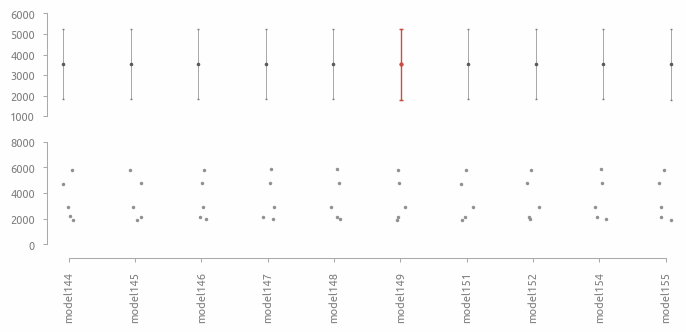

In [332]:
fig, ax = plt.subplots(2, 1, figsize=(8, 3))

ax[0].scatter(
    x = cv1_month_splits_desriptive_top.index,
    y = cv1_month_splits_desriptive_top['mean'],
    s=10)

ax[0].errorbar(
    x = cv1_month_splits_desriptive_top.index,
    y = cv1_month_splits_desriptive_top['mean'],
    yerr = cv1_month_splits_desriptive_top['std'],
    ls='none',
    lw=0.5,
    capsize=1,
    alpha=0.75)

# best model
ax[0].errorbar(
    x = cv1_month_splits_desriptive_top.loc[cv1_month_splits_best_model].name,
    y = cv1_month_splits_desriptive_top.loc[cv1_month_splits_best_model]['mean'],
    yerr = cv1_month_splits_desriptive_top.loc[cv1_month_splits_best_model]['std'],
    ls='none',
    lw=1,
    marker='.',
    markersize=4,
    capsize=1.5,
    color=saturate_color(palette[1], 1.5))

axis_rstyle(ax=ax[0], yticks=[1000, 6000, 1000], ylim=[1000, 6000], offset_left=7)
ax[0].spines['bottom'].set_visible(False)
ax[0].tick_params(bottom=False, labelbottom=False)

sns.stripplot(
    cv1_month_splits_top,
    s=5,
    color=palette[-2],
    ax=ax[1])

axis_rstyle(ax=ax[1], offset_left=7)

plt.xticks(rotation=90)
plt.subplots_adjust(hspace=0.25)

savefig('cv_results_plot', dir_save_img)

In [333]:
# top 5 model smoothed data
cv1_month_splits_top_smoothed = smoothed(cv1_month_splits_top[cv1_month_splits_top_models], n=200)

In [334]:
cv1_month_splits_top_smoothed

,model149,model155,model151,model145,model144,model152,model146,model154,model148,model147
0.000000,1934.091578,1934.231262,1930.001700,1929.709919,1905.319603,2011.125140,2011.103177,1998.537942,2002.382390,2009.542733
0.020101,1937.133034,1937.267017,1935.262103,1934.986651,1913.279167,2011.357526,2011.334408,1998.874381,2002.568536,2009.204716
0.040201,1940.084757,1940.213176,1940.349883,1940.090182,1920.998224,2011.570188,2011.546025,1999.198924,2002.746501,2008.874730
0.060302,1942.953898,1943.076888,1945.273339,1945.028821,1928.485778,2011.769434,2011.744339,1999.517697,2002.922367,2008.558646
0.080402,1945.747608,1945.865302,1950.040770,1949.810876,1935.750828,2011.961577,2011.935656,1999.836826,2003.102216,2008.262332
...,...,...,...,...,...,...,...,...,...,...
3.919598,5833.034348,5833.055681,5829.234426,5829.334161,5826.728639,5825.059723,5825.169713,5837.735502,5837.939285,5836.532564
3.939698,5836.441596,5836.463336,5832.099943,5832.176190,5829.957849,5828.521911,5828.635401,5841.917466,5842.157412,5840.824572
3.959799,5838.695174,5838.717334,5833.778596,5833.830411,5832.019277,5830.843452,5830.960588,5844.984588,5845.262103,5844.008510
3.979899,5839.776759,5839.799350,5834.251403,5834.277829,5832.894125,5832.006287,5832.127221,5846.919186,5847.235697,5846.066820


Images 'cv_models_plot.png' and 'cv_models_plot.svg' successfully saved into 'docs/img/' directory


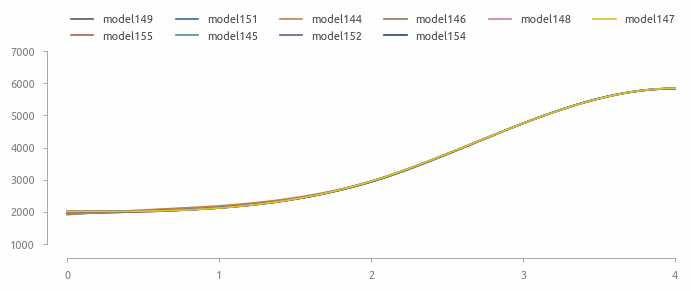

In [335]:
fig = plt.figure()

plt.plot(
    cv1_month_splits_top_smoothed
)
plt.legend(**legend_inline(), labels=cv1_month_splits_top_smoothed.columns);
ax_current().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
axis_rstyle(xticks=[0, 4, 1], offset_left=10)

savefig('cv_models_plot', dir_save_img)

In [336]:
cv1_month_period = train.loc['2017-03-01':'2017-07-30'].groupby('month').mean().copy()

In [337]:
cv1_month_period = train.loc['2017-03-01':'2017-07-30'].groupby('month').agg({'target1': ['mean', 'std']})

In [338]:
cv1_month_period.index = cv1_month_period.index - 3

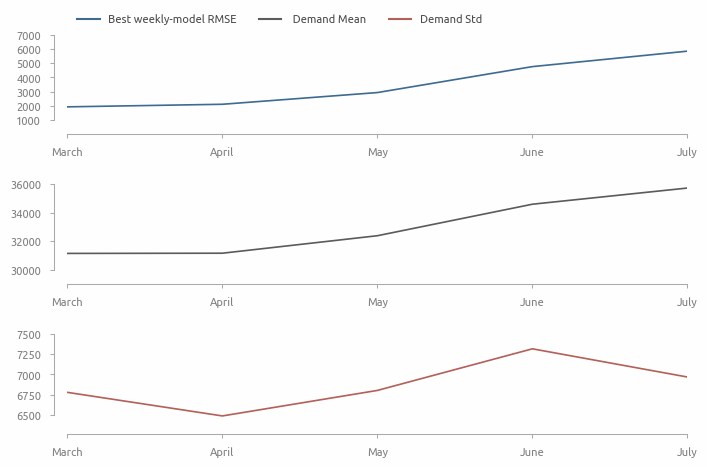

In [339]:
# top model

plt.figure(figsize=(8, 5))

plt.subplot(3, 1, 1)
plt.plot(
    cv1_month_splits_top[cv1_month_splits_best_model],
    color=palette[2],
    label=cv1_month_splits_best_model
)
# ax_current().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
axis_rstyle(xlim=[0, 4], xticks=[0, 4, 1], offset_left=10)
plt.xticks(arange(5), months_list[2:7])
# axis_remove_xaxis()
plt.legend(
    **legend_inline(3),
    **legend_create_handles(
        3,
        labels=['Best weekly-model RMSE', ' Demand Mean', 'Demand Std'],
        colors=[palette[2], palette[0], palette[1]]
    ));
# axis_remove_xaxis()

plt.subplot(3, 1, 2)
plt.plot(
    cv1_month_period['target1']['mean'],
    label='Mean'
)
axis_rstyle(xlim=[0, 4], xticks=[0, 4, 1], yticks=[30000, 36000, 2000], offset_left=10)
plt.xticks(arange(5), months_list[2:7])
# axis_remove_xaxis()

plt.subplot(3, 1, 3)
plt.plot(
    cv1_month_period['target1']['std'],
    color=palette[1],
    label='Std'
)
# ax_current().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
axis_rstyle(xlim=[0, 4], xticks=[0, 4, 1], yticks=[6500, 7500, 250], offset_left=10)

plt.xticks(arange(5), months_list[2:7])
plt.subplots_adjust(hspace=0.75)
plt.show()

In [340]:
train_by_week = train.loc['2017-02-01':].groupby(['month','week'])['target1'].mean().copy()

In [341]:
train_by_week = pd.DataFrame(train_by_week)

In [342]:
train_by_week['xticks'] = arange(len(train_by_week))

In [343]:
train_by_week.head(10)

target1  xticks
month week                      
2     5     30583.559322       0
      6     30620.320823       1
      7     31062.869249       2
      8     31481.355932       3
      9     31265.741525       4
3     9     30746.800000       5
      10    31181.975684       6
      11    31431.003040       7
      12    30691.173252       8
      13    31789.412766       9

In [344]:
months_list

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

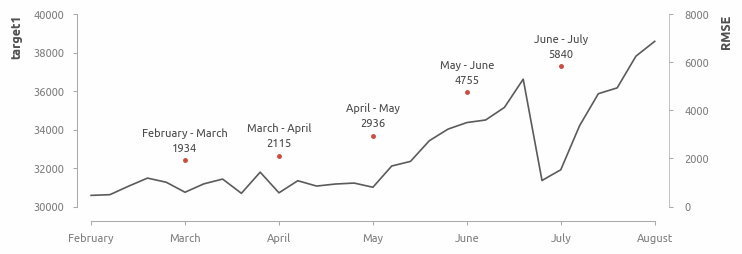

Images 'cv_rmse_plot.png' and 'cv_rmse_plot.svg' successfully saved into 'docs/img/' directory


In [616]:
fig, ax1 = plt.subplots()

ax1.plot(train_by_week['xticks'], train_by_week['target1'])
ax1.set_xticks([0, 5, 10, 15, 20 , 25, 30], months_list[1:8])
ax1.set_ylabel('target1')
axis_rstyle(offset_left=-10, ax=ax1)

ax2 = ax1.twinx()
ax2.scatter(
    x=[5, 10, 15, 20 , 25],
    y=cv1_month_splits_top[cv1_month_splits_best_model],
    color=saturate_color(palette[1], 1.5),
    s=25
)
months_rmse_names = [
    'February - March', 'March - April', 'April - May', 'May - June', 'June - July'
]
for i, j, k in zip(
    [5, 10, 15, 20 , 25],
    cv1_month_splits_top[cv1_month_splits_best_model],
    months_rmse_names):
        ax2.annotate(text=k, xy=(i, j+990),
                     size=8, ha='center')
        ax2.annotate(text=int(round(j, 0)), xy=(i, j+365),
                     size=8, ha='center')

ax2.set_ylim(0, 8000)
ax2.grid(False)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color('#AAAAAA')
ax2.spines[['left', 'bottom']].set_visible(False)
ax2.tick_params(axis='y', direction='out', color='#AAAAAA', size=3)
ax2.tick_params(labelcolor='#808080')
# ax2.spines['right'].set_bounds(0, 0.25)
ax2.spines['right'].set_position(('outward', -10))
ax2.set_yticks(arange(0, 8001, 2000))
ax2.set_ylabel('RMSE')

plt.show()

savefig('cv_rmse_plot', dir_save_img)

In [594]:
cv1_month_splits_top[cv1_month_splits_best_model].diff().round(0).fillna(0).astype(int)

0       0
1     181
2     821
3    1820
4    1084
Name: model149, dtype: int64

In [329]:
cv1_month_splits_best_model

'model149'

In [358]:
cv1_month_models[cv1_month_splits_best_model]

((4, 1, 2), [144, 72, 36], [5, 1, 6])

#### Check only 3 first folds

Because last 2 are not relevant

In [352]:
cv1_month_splits_ = cv1_month_splits.iloc[:3, :].copy()

In [353]:
cv1_month_splits_

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,...,model206,model207,model208,model209,model210,model211,model212,model213,model214,model215
0,4412.813788,4602.658003,4710.139080,4768.266436,4728.227331,4612.565384,4412.770941,4602.690203,4710.146020,4768.278251,...,1979.121456,1918.732085,1919.300417,1919.219868,1979.121157,1979.121261,1979.121203,1947.419687,1919.298083,1919.217728
1,4441.251986,4198.012464,3959.888540,3895.056710,3915.126401,3854.236007,4441.368449,4197.831084,3959.878938,3895.057018,...,2160.700726,2156.979133,2161.099976,2153.990920,2160.697936,2160.698231,2160.708174,2156.999367,2161.264222,2154.000091
2,4745.921189,4301.164091,4282.260462,4389.915973,4431.743804,4366.073079,4745.921211,4301.164115,4282.260477,4389.915992,...,2924.616808,2953.067258,2952.776962,2934.310173,2924.616851,2924.616808,2924.616808,2953.067864,2952.777054,2934.310166


In [355]:
cv1_month_splits_.mean().sort_values()

model149    2328.159956
model155    2328.203952
model145    2333.824723
model151    2333.921378
model179    2335.838130
               ...     
model12     4635.885641
model61     4643.591944
model24     4643.670888
model60     4643.701789
model25     4643.704037
Length: 216, dtype: float64

In [357]:
cv1_month_models['model149']

((4, 1, 2), [144, 72, 36], [5, 1, 6])

#### Final Model

In [360]:
arima1_month = cv1_month_models['model149']

In [361]:
cv1_month_splits_desriptive_top.loc['model149']

mean     3515.891354
std      1713.061351
lower    2370.871386
upper    5042.019688
Name: model149, dtype: float64

In [362]:
cv1_month_splits['model149']

0    1934.091578
1    2114.602804
2    2935.785485
3    4755.308877
4    5839.668026
Name: model149, dtype: float64

In [363]:
arima1_month

((4, 1, 2), [144, 72, 36], [5, 1, 6])

### ARIMA with exogs variables

In [113]:
# NULL: non-stationarity
sm.tsa.stattools.adfuller(train.loc['2017-07-01':, 'temperature'])

(-10.36173182087001,
 2.3867510600262185e-18,
 27,
 4436,
 {'1%': -3.4318249973120594,
  '5%': -2.8621917710771485,
  '10%': -2.5671169416654944},
 -1287.539719272837)

In [114]:
# NULL: non-stationarity
sm.tsa.stattools.adfuller(train.loc['2017-07-01':, 'target1_previous_month'])

(-10.878385594286243,
 1.3137803449282866e-19,
 25,
 4438,
 {'1%': -3.4318243322143682,
  '5%': -2.8621914772569323,
  '10%': -2.567116785250736},
 67666.12586660299)

In [115]:
features = [
    'temperature', 'humidity', 'windspeed', 'minute', 'hour', 'weekday', 
    'is_Friday', 'is_Sunday', 'is_31', 'target1_previous_month', 'minute_of_day']

In [116]:
features = [
    'temperature', 'humidity', 'windspeed',
    'is_Friday', 'is_Sunday', 'is_31', 'target1_previous_month']

### Forecasts

In [520]:
arima_month_order = arima1_month[0]
arima_month_fourier_period = arima1_month[1]
arima_month_fourier_order = arima1_month[2]

In [521]:
arima_month_order, arima_month_fourier_period, arima_month_fourier_order

((4, 1, 2), [144, 72, 36], [5, 1, 6])

#### August forecast

In [522]:
train_august_month = train.loc['2017-07-01':, 'target1'].copy()

In [523]:
train_august_month_exogs_df = train.loc['2017-07-01':, features].copy()

In [524]:
test_august_month = valid['target1'].copy()

In [525]:
test_august_month_exogs_df = valid.loc['2017-08-01':, features].copy()

In [526]:
train_august_month_exogs, test_august_month_exogs = \
    ts_arima_fourier_get_exogs(
        fourier_period=arima_month_fourier_period,
        fourier_order=arima_month_fourier_order,
        train_data=train_august_month,
        test_data=test_august_month)

In [527]:
test_august_month_exogs = test_august_month_exogs.join(
    test_august_month_exogs_df
)

In [528]:
%%time
model_month = fit_model_with_fourier(
    order=arima_month_order,
    fourier_period=arima_month_fourier_period,
    fourier_order=arima_month_fourier_order,
    train_data=train_august_month,
    exog=train_august_month_exogs_df
)

/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


CPU times: user 2min 42s, sys: 32.1 s, total: 3min 14s
Wall time: 1min 28s


In [529]:
forecast_month = model_month.get_forecast(steps=len(test_august_month), exog=test_august_month_exogs)

In [530]:
y_pred = forecast_month.predicted_mean

###### MAE

In [531]:
mean_absolute_error(test_august_month, y_pred)

1631.4608618214113

###### MAPE

In [532]:
mean_absolute_percentage_error(test_august_month, y_pred) * 100

4.627955272276528

###### RMSE

In [533]:
root_mean_squared_error(y_true, y_pred)

2133.701667470128

Images 'forecast_august_plot.png' and 'forecast_august_plot.svg' successfully saved into 'docs/img/' directory


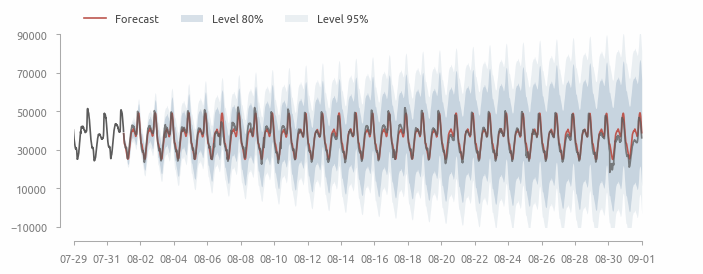

In [560]:
ts_plot_arima_forecast(
    model=model_month, steps=len(test_august_month),
    data=train_august_month.to_frame(), exog=test_august_month_exogs)
plt.plot(test_august_month, color=palette[0], alpha=0.75)

ax_current().set_xlim(dt.date(2017, 7, 30))
ax_current().set_ylim(-10000, 90000)
ax_current().set_xticks(ticks=pd.date_range(start='2017-07-29', end='2017-09-01', freq='2d'))
ax_current().xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%m-%d'))
axis_rstyle(yticks=[-10000, 100000], offset_left=10)

savefig('forecast_august_plot', dir_save_img)

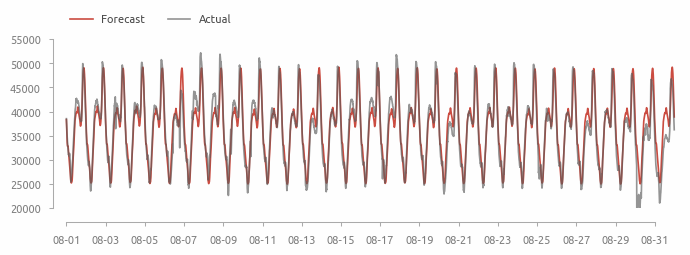

In [555]:
plt.plot(
    y_pred.index,
    y_pred,
    label='Forecast',
    color=saturate_color(palette[1], 1.5))
plt.plot(
    valid['target1'],
    label='Actual',
    color=palette[0],
    alpha=0.65
    );

ax_current().set_xticks(ticks=pd.date_range(start='2017-08-01', end='2017-09-01', freq='2d'))
ax_current().xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%m-%d'))
axis_rstyle(ylim=[20000, 60000])
plt.legend(**legend_inline(bbox_to_anchor=(0, 0.9)))
plt.show()

In [536]:
print(model_month.summary())

                               SARIMAX Results                                
Dep. Variable:                target1   No. Observations:                 4464
Model:               SARIMAX(4, 1, 2)   Log Likelihood              -33084.610
Date:                Sun, 14 Apr 2024   AIC                          66245.220
Time:                        12:19:33   BIC                          66488.556
Sample:                    07-01-2017   HQIC                         66330.998
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
sin(1,36)               -344.3865     25.790    -13.353      0.000    -394.934    -293.839
cos(1,36)               -846.1133     24.451    -34.604      0.000    -894.037    -798.189
sin(

### Residuals research

In [537]:
resid =  y_pred - y_true

In [538]:
test_normality(resid)

,Test,P or Statistic (s),Condition
0,Kolmogorov-Smirnov,0.0000,Not normal
1,Anderson-Darling (s),7.5226,Not normal
2,Shapiro-Wilk,0.0000,Not normal
3,Jarque-Bera,0.0000,Not normal
4,D’Agostino-Pearson,0.0000,Not normal


In [539]:
np.std(resid)

2130.131451539697

In [540]:
len(resid)

4464

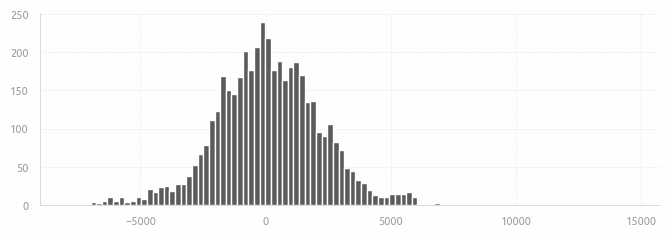

In [541]:
plt.hist(resid, bins=100);

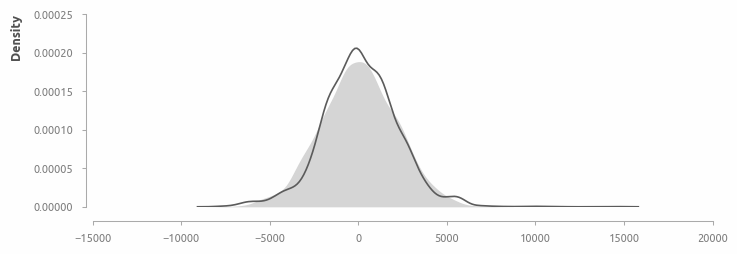

In [542]:
sns.kdeplot(resid, color=palette[0]);
sns.kdeplot(np.random.normal(0, np.std(resid), len(resid)), color=palette[0], fill=True, lw=0.01);
axis_rstyle()
plt.show()

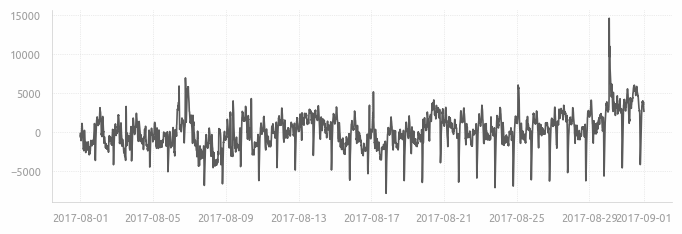

In [543]:
plt.plot(resid);

In [544]:
resid_mean = resid.groupby(resid.index.floor('D')).mean()

In [545]:
resid_mean.sort_values()

2017-08-08   -2168.265549
2017-08-07   -1599.542896
2017-08-17   -1460.234607
2017-08-05   -1015.544269
2017-08-01    -984.685141
2017-08-16    -861.850581
2017-08-15    -719.261187
2017-08-19    -676.994002
2017-08-18    -671.410076
2017-08-03    -624.191094
2017-08-04    -547.308839
2017-08-09    -502.072561
2017-08-10    -463.329077
2017-08-02    -455.842843
2017-08-24    -231.121404
2017-08-11    -226.033424
2017-08-23       1.039745
2017-08-22      22.778649
2017-08-26     234.904545
2017-08-12     266.944769
2017-08-28     296.256167
2017-08-25     468.178856
2017-08-21     519.594055
2017-08-14     753.016059
2017-08-29    1202.400621
2017-08-27    1327.733386
2017-08-06    1440.430435
2017-08-13    1512.041072
2017-08-20    1768.480324
2017-08-30    3583.634501
2017-08-31    3635.057043
dtype: float64

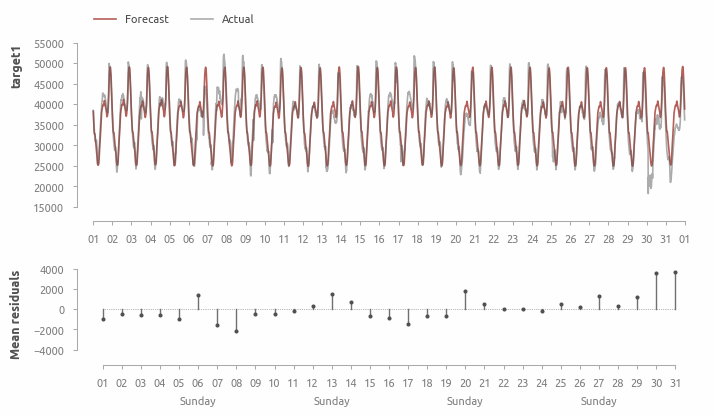

Images 'forecast_august_resid_mean_plot.png' and 'forecast_august_resid_mean_plot.svg' successfully saved into 'docs/img/' directory


In [546]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4), height_ratios=[2, 1])

ax[0].plot(y_pred.index, y_pred, color=palette[1], label='Forecast')
ax[0].plot(y_true.index, y_true, color=palette[0], alpha=0.5, label='Actual')

ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%d'))
ax[0].xaxis.set_major_locator(mpl.dates.DayLocator())

ax[0].set_xlim(y_pred.index[0]-dt.timedelta(days=0.5), y_pred.index[-1]+dt.timedelta(days=1))
ax[0].set_ylabel('target1')
axis_rstyle(ax=ax[0])
ax[0].legend(**legend_inline(bbox_to_anchor=(0, 1.05)))

for i in resid_mean.index:
    ax[1].plot([i, i], [0, resid_mean[i]], color=palette[-3], lw=1)
    ax[1].scatter(i, resid_mean[i], s=15, color=palette[-4], zorder=10)

ax[1].plot(
    [resid_mean.index[0], resid_mean.index[-1]],
    [0, 0],
    lw=0.5, ls=':', color=palette[-3])

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%d'))
ax[1].xaxis.set_major_locator(mpl.dates.DayLocator())
ax1_axis_sec =  ax[1].secondary_xaxis('bottom')
ax1_axis_sec.spines['bottom'].set_visible(False)
ax1_axis_sec.tick_params(pad=32, bottom=False, colors='#808080')
ax1_axis_sec.xaxis.set_major_locator(mpl.dates.WeekdayLocator(mpl.dates.SU))
ax1_axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))

ax[1].set_xlim(y_pred.index[0]-dt.timedelta(days=1), y_pred.index[-1]+dt.timedelta(days=0.5))
ax[1].set_ylabel('Mean residuals')

axis_rstyle(xslice=[1, -1], ylim=[-4100, 4000], ax=ax[1])

plt.subplots_adjust(hspace=0.5)
plt.show()

savefig('forecast_august_resid_mean_plot', dir_save_img)

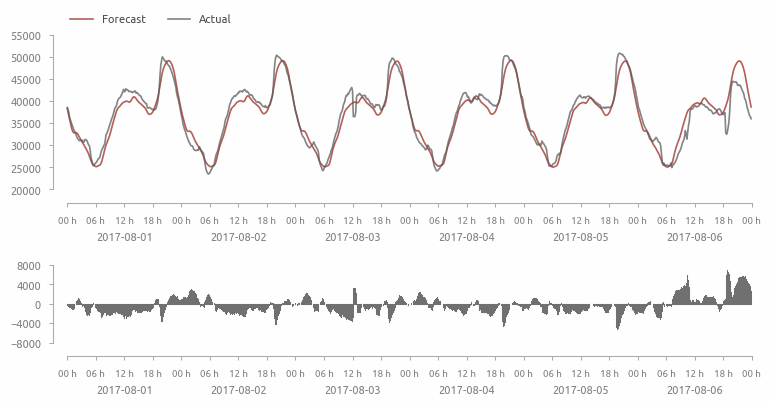

Images 'forecast_august_detail_plot_week1.png' and 'forecast_august_detail_plot_week1.svg' successfully saved into 'docs/img/' directory


In [547]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-01':'2017-08-06'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-01':'2017-08-06'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec = ax[0].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(ax=ax[0], xslice=[1, -1])
ax[0].legend(**legend_inline())
# ax[0].set_ylabel('target1')

for i in resid.loc['2017-08-01':'2017-08-06'].index:
    plt.plot(
        [i, i], [0, resid[i]], color=palette[-3], lw=0.75)

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(xslice=[1, -1], yticks=[-8000, 8000, 4000], ylim=[-8000, 8000], ax=ax[1])
# ax[1].set_ylabel('Residuals')

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('forecast_august_detail_plot_week1', dir_save_img)

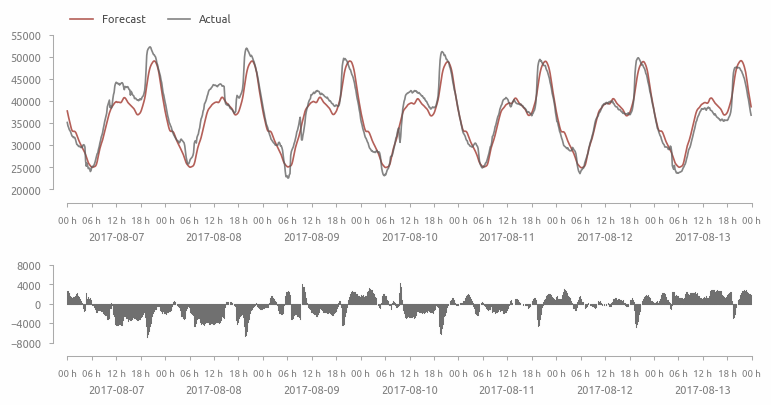

Images 'forecast_august_detail_plot_week2.png' and 'forecast_august_detail_plot_week2.svg' successfully saved into 'docs/img/' directory


In [548]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-07':'2017-08-13'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-07':'2017-08-13'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec = ax[0].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(ax=ax[0], xslice=[1, -1],)
ax[0].legend(**legend_inline())

for i in resid.loc['2017-08-07':'2017-08-13'].index:
    plt.plot(
        [i, i], [0, resid[i]], color=palette[-3], lw=0.75)

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(yticks=[-8000, 8000, 4000], ylim=[-8000, 8000], ax=ax[1], xslice=[1, -1])

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('forecast_august_detail_plot_week2', dir_save_img)

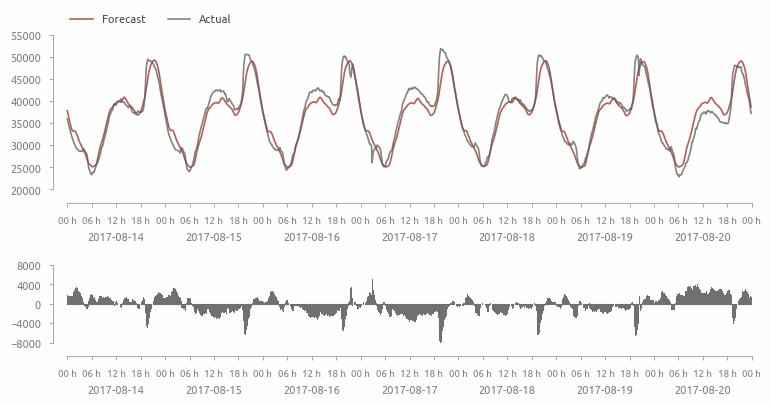

Images 'forecast_august_detail_plot_week3.png' and 'forecast_august_detail_plot_week3.svg' successfully saved into 'docs/img/' directory


In [549]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-14':'2017-08-20'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-14':'2017-08-20'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec = ax[0].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(ax=ax[0], xslice=[1, -1],)
ax[0].legend(**legend_inline())

for i in resid.loc['2017-08-14':'2017-08-20'].index:
    plt.plot(
        [i, i], [0, resid[i]], color=palette[-3], lw=0.75)

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(xslice=[1, -1], yticks=[-8000, 8000, 4000], ylim=[-8000, 8000], ax=ax[1])

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('forecast_august_detail_plot_week3', dir_save_img)

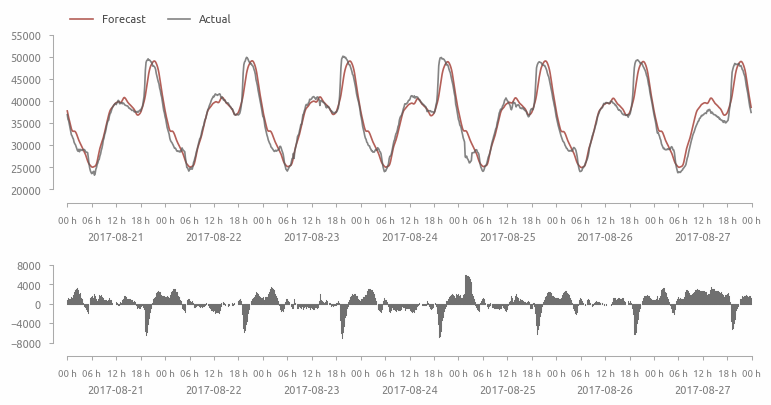

Images 'forecast_august_detail_plot_week4.png' and 'forecast_august_detail_plot_week4.svg' successfully saved into 'docs/img/' directory


In [550]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-21':'2017-08-27'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-21':'2017-08-27'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec = ax[0].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(ax=ax[0], xslice=[1, -1],)
ax[0].legend(**legend_inline())

for i in resid.loc['2017-08-21':'2017-08-27'].index:
    plt.plot(
        [i, i], [0, resid[i]], color=palette[-3], lw=0.75)

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.DayLocator(arange(21, 27, True)))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(xslice=[1, -1],yticks=[-8000, 8000, 4000], ylim=[-8000, 8000], ax=ax[1])

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('forecast_august_detail_plot_week4', dir_save_img)

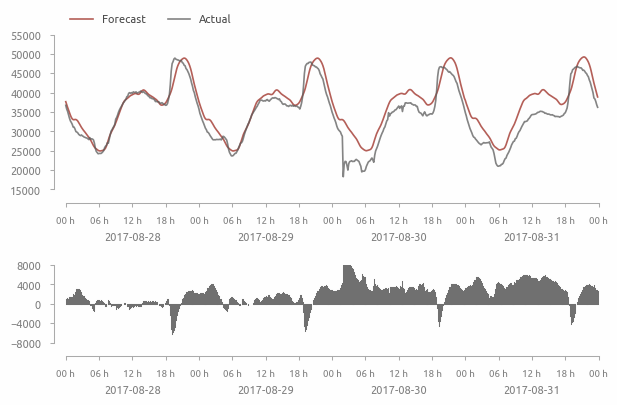

Images 'forecast_august_detail_plot_week5.png' and 'forecast_august_detail_plot_week5.svg' successfully saved into 'docs/img/' directory


In [551]:
fig, ax = plt.subplots(2, 1, figsize=(7, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-28':'2017-08-31'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-28':'2017-08-31'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec = ax[0].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(
    fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
# axis_sec.xaxis.set_major_locator(mpl.dates.DayLocator(arange(28, 31, True)))
axis_rstyle(ax=ax[0])
ax[0].legend(**legend_inline())

for i in resid.loc['2017-08-28':'2017-08-31'].index:
    plt.plot(
        [i, i], [0, resid[i]], color=palette[-3], lw=0.75)

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(yticks=[-8000, 8000, 4000], ylim=[-8000, 8000], ax=ax[1])

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('forecast_august_detail_plot_week5', dir_save_img)

## Save Data

### Save Session

In [148]:
save_session(session_name)

### Execution time

In [149]:
print(f'Execution time: {stopwatch.stop(start)}')

Execution time: 8:45:54
